In [1]:
%matplotlib notebook
%pylab
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyradise as prs

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#
# Definining reader, tag and wireless transmission, or environment, parameters.
#

# environment parameters
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wave_length = speed_of_light / frequency
thermal_noise = -116 #dBm
permittivity = 15
conductivity = 0.03

# reader paramters
reader_height = 5.0 #m
reader_angle  = pi/3
reader_tx_power = 31.5 #dBm
reader_antenna_gain = 8 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 

# tag parameters 
tag_speed = 60/3.6 #mps
tag_height = 0.5 #m
tag_angle  = pi/2
tag_antenna_gain = 2 #dBi 
tag_modulation_loss = -12.0 #dB
tag_sensitivity=-18.5 #dBm

# mutual parameters
polarization_loss = -6.0 #dB
ceil_height = 6

In [3]:
def patch_rp_(theta, phi):
    return prs.patch_rp(azimuth=theta, tilt=phi, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def reflection_paral_(phi):
    return prs.reflection(grazing_angle=phi, polarization=1., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_perp_(phi):
    return prs.reflection(grazing_angle=phi, polarization=0., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_circ_(phi):
    return prs.reflection(grazing_angle=phi, polarization=.5, permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)


def fspl_(distance):
    return prs.free_space_path_loss_2d(distance=distance, 
            tx_rp=prs.patch_rp, rx_rp=prs.dipole_rp, tx_angle=reader_angle, rx_angle=tag_angle, tx_height=reader_height, 
            rx_height=tag_height, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def two_ray_(distance, time, speed, polarization):
    return prs.two_ray_path_loss(distance=distance, time=time, speed=speed, ground_reflection=prs.reflection,
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_rp=prs.patch_rp, rx_rp=prs.dipole_rp, tx_angle=reader_angle, rx_angle=tag_angle, tx_height=reader_height, 
            rx_height=tag_height, wavelen=wave_length, width=wave_length/2, length=wave_length/2)


def make_space_time_greed_(distance, time, function, **kwargs):
    return np.array([[function(distance=d, time=t, **kwargs) for d in distance] for t in time])


In [4]:
#
# Link budget computation
#
def rx_power_tag_(pathloss):
    return (reader_tx_power + reader_antenna_gain + reader_cabel_loss + 
            pathloss + tag_antenna_gain + polarization_loss)

def tx_power_tag_(rx_power_tag):
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise

def rx_power_reader_(pathloss, tx_power_tag):    
    return (tx_power_tag + tag_antenna_gain + pathloss + polarization_loss +
                reader_cabel_loss + reader_antenna_gain) if tx_power_tag >= reader_noise else thermal_noise


def rx_power_tag_complete_(distance, time, speed):
    pathloss_fwd = prs.lin2db(two_ray_(distance, time, speed, .5))  # computing path loss from reader to tag 
    return rx_power_tag_(pathloss_fwd)

def rx_power_reader_complete_(distance, time, speed):
    pathloss_fwd = prs.lin2db(two_ray_(distance, time, speed, .5))  # computing path loss from reader to tag 
    rx_power_tag = rx_power_tag_(pathloss_fwd)                      # computing RX power at tag
    tx_power_tag = tx_power_tag_(rx_power_tag)                      # computing TX power of tag
    pathloss_bwd = prs.lin2db(two_ray_(distance, time, speed, 1.))  # computing path loss from tag to reader
    return rx_power_reader_(pathloss_bwd, tx_power_tag)

#
# SNR and BER computation
#
def snr_(distance, time, speed):
    rx_power = rx_power_reader_complete_(distance, time, speed)
    return prs.signal2noise(rx_power=rx_power, noise_power=reader_noise)

def ber_over_awgn_(distance, time, speed):
    snr = snr_(distance, time, speed)
    sync_angle = prs.sync_angle(snr=snr)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle)
    return prs.ber_over_awgn(snr=snr_extended)

def ber_over_rayleigh_(distance, time, speed):
    snr = snr_(distance, time, speed)
    sync_angle = prs.sync_angle(snr=snr)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle)
    return prs.ber_over_rayleigh(snr=snr_extended)


In [5]:
#
# Antenna gain computation
#
def antenna_gain_(radiation_pattern, theta, **kwargs):
    max_gain  = radiation_pattern(azimuth=0, **kwargs)
    mean_gain = np.sum([radiation_pattern(azimuth=t, **kwargs) for t in theta]) / theta.size
    return prs.lin2db(max_gain / mean_gain)

def antenna_gain_2d_(radiation_pattern, theta, tilt, **kwargs):
    max_gain  = radiation_pattern(0, tilt, **kwargs)
    mean_gain = np.sum([radiation_pattern(t, tilt, **kwargs) for t in theta]) / theta.size
    return prs.lin2db(max_gain / mean_gain)

theta = np.linspace(-pi, pi, num=100)

gain_iso = antenna_gain_(prs.isotropic_rp, theta)
gain_dip = antenna_gain_(prs.dipole_rp, theta)
gain_arr = antenna_gain_(prs.array_dipole_rp, theta, n=2)
gain_hel = antenna_gain_(prs.helix_rp, theta, n=3)

print(gain_iso, gain_dip, gain_arr, gain_hel)

gain_patch_0 = antenna_gain_2d_(patch_rp_, theta, 0.0)
gain_patch_1 = antenna_gain_2d_(patch_rp_, theta, pi/6)
gain_patch_2 = antenna_gain_2d_(patch_rp_, theta, pi/4)
gain_patch_3 = antenna_gain_2d_(patch_rp_, theta, pi/3)
gain_patch_4 = antenna_gain_2d_(patch_rp_, theta, pi/12*5)

print(gain_patch_0, gain_patch_1, gain_patch_2, gain_patch_3, gain_patch_4)

0.0 5.34902997531 6.31453521643 5.39270525379
6.31453521643 5.67962938579 5.33439366681 5.25287148212 5.41778610609


<IPython.core.display.Javascript object>


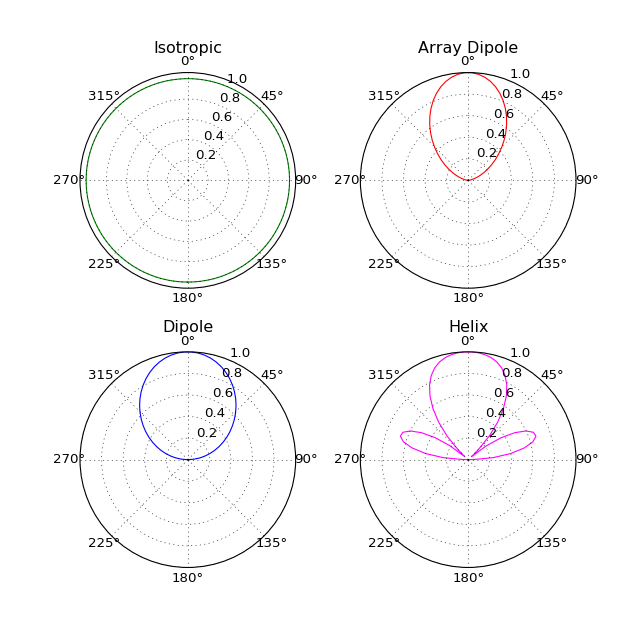

In [6]:
#
# Plotting radiation pattern of different antennas
#
theta = np.linspace(-pi, pi, num=100)
r1 = [prs.isotropic_rp(azimuth=t) for t in theta]
r2 = [prs.dipole_rp(azimuth=t) for t in theta]
r3 = [prs.array_dipole_rp(azimuth=t, n=2) for t in theta]
r4 = [prs.helix_rp(azimuth=t, n=3) for t in theta]

figure(1, figsize=(8,8))
ax1 = subplot2grid((2,2), (0,0), projection='polar')
ax2 = subplot2grid((2,2), (1,0), projection='polar')
ax3 = subplot2grid((2,2), (0,1), projection='polar')
ax4 = subplot2grid((2,2), (1,1), projection='polar')

ax1.plot(theta, r1, color='green', linewidth=1)
ax2.plot(theta, r2, color='blue', linewidth=1)
ax3.plot(theta, r3, color='red', linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')

ax1.set_title("Isotropic", va='bottom')
ax2.set_title("Dipole", va='bottom')
ax3.set_title("Array Dipole", va='bottom')
ax4.set_title("Helix", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

# ax.set_rscale('log')
# ax.set_rmax(0.008)
# ax.grid(True)

<IPython.core.display.Javascript object>


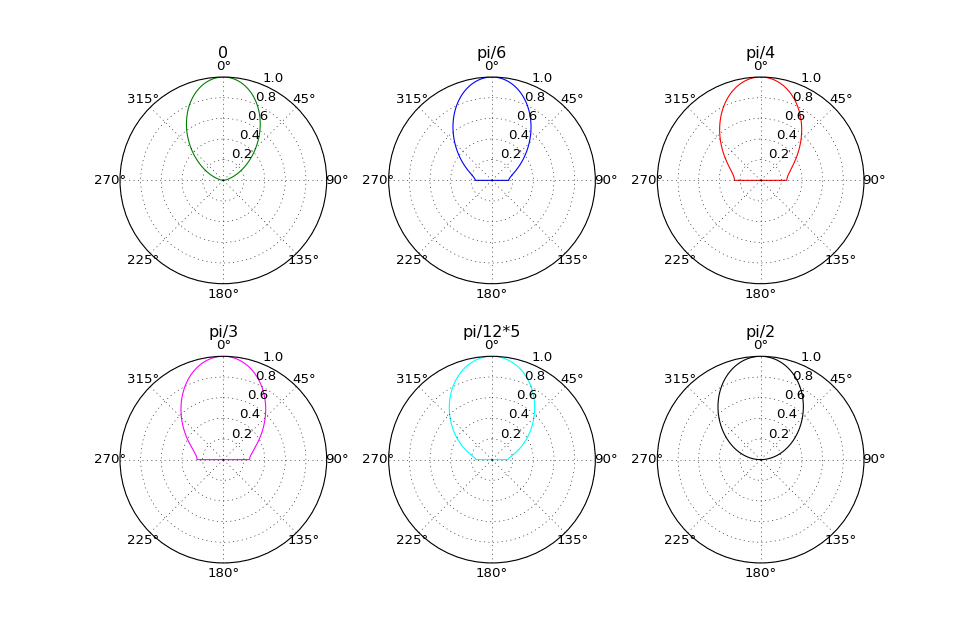

In [7]:
theta = np.linspace(-pi, pi, num=1000)

def log_rp(theta, phi, rp): 
    value = w2db(rp(theta, phi)) + 40
    if (value < 0):
        return 0
    else:
        return value


r1 = [patch_rp_(t, 0.0)  for t in theta]
r2 = [patch_rp_(t, pi/6) for t in theta]
r3 = [patch_rp_(t, pi/4) for t in theta]
r4 = [patch_rp_(t, pi/3) for t in theta]
r5 = [patch_rp_(t, pi/12*5) for t in theta]
r6 = [patch_rp_(t, pi/2) for t in theta]

# r1 = prs.patch_rp(azimuth=theta, tilt=0.001, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r2 = prs.patch_rp(azimuth=theta, tilt=pi/12, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r3 = prs.patch_rp(azimuth=theta, tilt=pi/6,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r4 = prs.patch_rp(azimuth=theta, tilt=pi/4,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r5 = prs.patch_rp(azimuth=theta, tilt=pi/3,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r6 = prs.patch_rp(azimuth=theta, tilt=pi/2,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)

figure(2, figsize=(12,8))
ax1 = subplot2grid((2,3), (0,0), projection='polar')
ax2 = subplot2grid((2,3), (0,1), projection='polar')
ax3 = subplot2grid((2,3), (0,2), projection='polar')
ax4 = subplot2grid((2,3), (1,0), projection='polar')
ax5 = subplot2grid((2,3), (1,1), projection='polar')
ax6 = subplot2grid((2,3), (1,2), projection='polar')

ax1.plot(theta, r1, color='green',   linewidth=1)
ax2.plot(theta, r2, color='blue',    linewidth=1)
ax3.plot(theta, r3, color='red',     linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)
ax5.plot(theta, r5, color='cyan',    linewidth=1)
ax6.plot(theta, r6, color='black',   linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')
ax5.set_theta_zero_location('N')
ax6.set_theta_zero_location('N')

ax1.set_title("0", va='bottom')
ax2.set_title("pi/6", va='bottom')
ax3.set_title("pi/4", va='bottom')
ax4.set_title("pi/3", va='bottom')
ax5.set_title("pi/12*5", va='bottom')
ax6.set_title("pi/2", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)
ax5.set_theta_direction(-1)
ax6.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

<IPython.core.display.Javascript object>


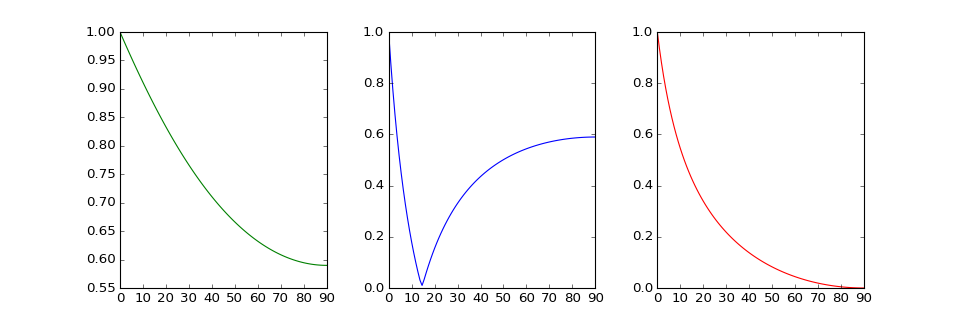

In [8]:
phi = np.linspace(0.0, pi/2, num=100)
r_pl = [np.absolute(reflection_paral_(t)) for t in phi]
r_pp = [np.absolute(reflection_perp_(t))  for t in phi]
r_c  = [np.absolute(reflection_circ_(t))  for t in phi]

figure(3, figsize=(12,4))
ax1 = subplot2grid((1,3), (0,0))
ax2 = subplot2grid((1,3), (0,1))
ax3 = subplot2grid((1,3), (0,2))

ax1.plot(phi*180/pi, r_pl, color='green', linewidth=1)
ax2.plot(phi*180/pi, r_pp, color='blue', linewidth=1)
ax3.plot(phi*180/pi, r_c, color='red', linewidth=1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

<IPython.core.display.Javascript object>


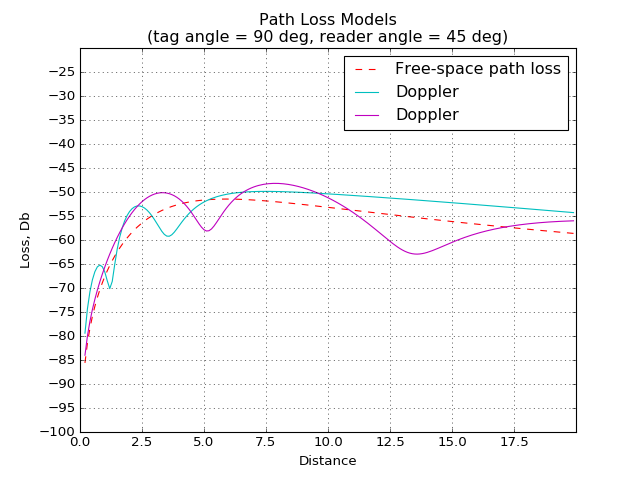

In [9]:
dist = arange(0.2, 20, 0.1)
free_space_pl = [prs.lin2db(fspl_(d)) for d in dist]
two_ray_pl = [prs.lin2db(two_ray_(d, 0.3, 20, 1)) for d in dist]
two_ray_pl2= [prs.lin2db(two_ray_(d, 0.3, 0, 1)) for d in dist]

fig = figure(4)
ax = subplot(111)
plot(dist, free_space_pl,'r--', label='Free-space path loss')
plot(dist, two_ray_pl,   'c',   label='Doppler')
plot(dist, two_ray_pl2,  'm',   label='Doppler')

grid(True)
ax.set_ybound(lower=-100, upper=-20)
ax.set_xticks(arange(0, 20, 2.5))
ax.set_yticks(arange(-100, -20, 5))
ax.set_xlabel("Distance")
ax.set_ylabel("Loss, Db")
ax.set_title('Path Loss Models\n(tag angle = 90 deg, reader angle = 45 deg)')
legend()

In [14]:
distance = np.linspace(2, 10., 1000)
time     = np.linspace(0, 2, 1000)

pathloss_greed = prs.lin2db(make_space_time_greed_(distance, time, two_ray_, speed=tag_speed, polarization=1))
rx_tag_greed       = make_space_time_greed_(distance, time, rx_power_tag_complete_, speed=tag_speed)
rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_, speed=tag_speed)
ber_awgn_greed     = make_space_time_greed_(distance, time, ber_over_awgn_, speed=tag_speed)
ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_, speed=tag_speed)

<IPython.core.display.Javascript object>


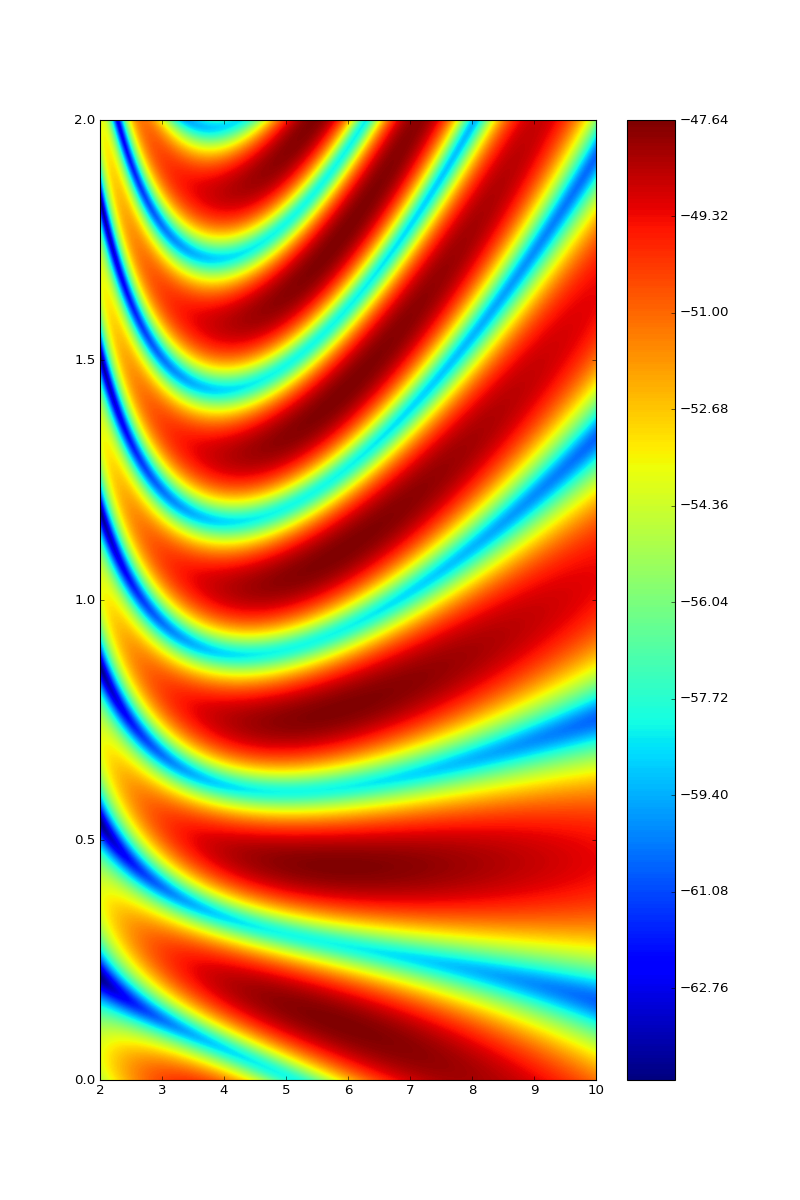

In [17]:
fig = plt.figure(5, figsize=(10,15))

D,T = meshgrid(distance, time)
P = pathloss_greed
plt.contourf(D, T, P, 500)            
plt.colorbar()
# savefig('100kmps_4sec.png')

<IPython.core.display.Javascript object>


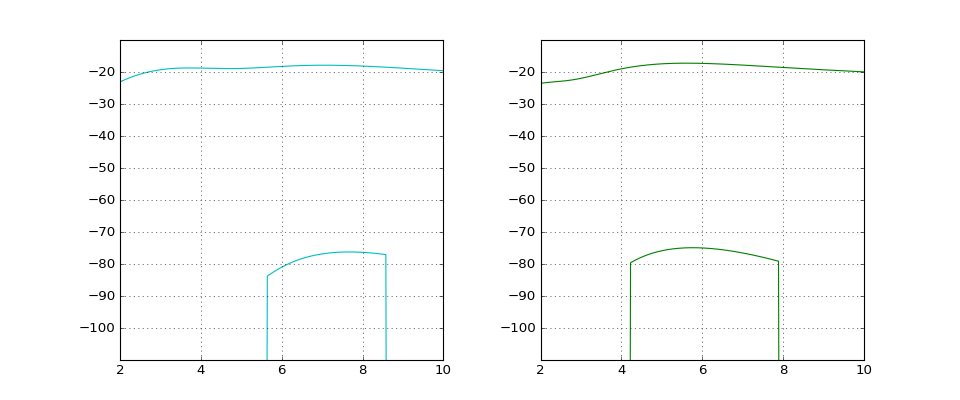

In [18]:
fig = figure(6, figsize=(12,5))

ax1 = subplot2grid((1,2), (0,0))
ax2 = subplot2grid((1,2), (0,1))

ax1.set_xticks(arange(0, 14, 2))
ax1.set_yticks(arange(-100, -10, 10))
ax1.set_ylim(-110, -10)
ax2.set_xticks(arange(0, 14, 2))
ax2.set_yticks(arange(-100, -10, 10))
ax2.set_ylim(-110, -10)

rx_power_tag_1 = [rx_power_tag_(prs.lin2db(two_ray_(d, 0., 0, .5))) for d in distance]
tx_power_tag_1 = [tx_power_tag_(rx) for rx in rx_power_tag_1]
rx_power_reader_1 = [rx_power_reader_(prs.lin2db(two_ray_(distance[i], 0., 0, 1)), tx_power_tag_1[i]) 
                     for i in range(distance.size)]

rx_power_tag_2 = [rx_power_tag_(prs.lin2db(two_ray_(d, 0.1, 20, .5))) for d in distance]
tx_power_tag_2 = [tx_power_tag_(rx) for rx in rx_power_tag_2]
rx_power_reader_2 = [rx_power_reader_(prs.lin2db(two_ray_(distance[i], 0.1, 20, 1)), tx_power_tag_2[i]) 
                     for i in range(distance.size)]
    
ax1.plot(distance, rx_power_tag_1, 'c', label='RX at tag (forward)')
ax1.plot(distance, rx_power_reader_1, 'c', label='RX at reader (backscattered)')

ax2.plot(distance, rx_power_tag_2, 'g', label='RX at tag (forward)')
ax2.plot(distance, rx_power_reader_2, 'g', label='RX at reader (backscattered)')

ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

<IPython.core.display.Javascript object>


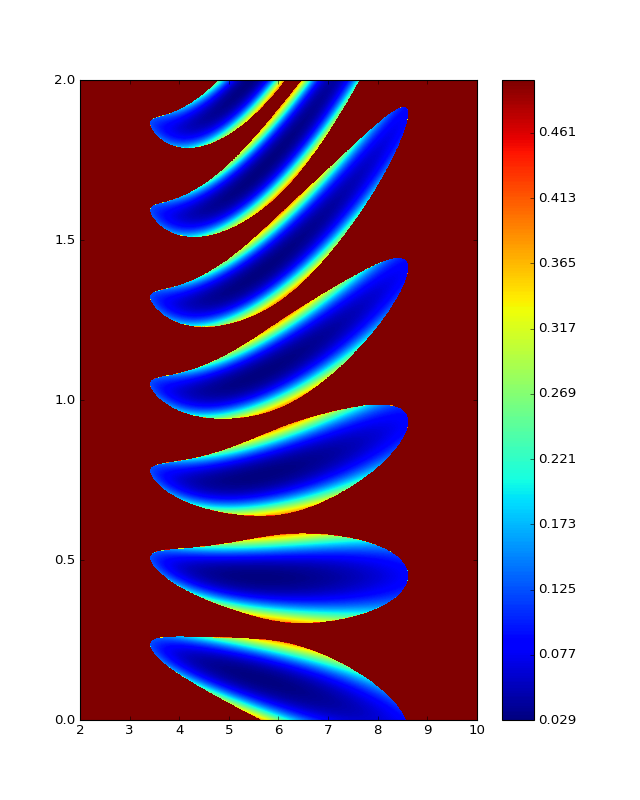

In [19]:
fig = plt.figure(7, figsize=(8,10))
D,T = meshgrid(distance, time)
P = ber_awgn_greed
plt.contourf(D, T, P, 500)                             
plt.colorbar()

In [10]:
def two_ray_2_(distance, start_position, polarization):
    return prs.two_ray_path_loss_2d(distance=distance, start_position=start_position, ground_reflection=prs.reflection,
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_rp=prs.patch_rp, rx_rp=prs.dipole_rp, tx_angle=reader_angle, rx_angle=tag_angle, tx_height=reader_height, 
            rx_height=tag_height, wavelen=wave_length, width=wave_length/2, length=wave_length/2)


def make_space_time_greed_2_(distance, start_position, function, **kwargs):
    return np.array([[function(distance=d, start_position=sp, **kwargs) for d in distance] for sp in start_position])


def rx_power_tag_complete_2_(distance, start_position):
    pathloss_fwd = prs.lin2db(two_ray_2_(distance, start_position, .5))  # computing path loss from reader to tag 
    return rx_power_tag_(pathloss_fwd)

def rx_power_reader_complete_2_(distance, start_position):
    pathloss_fwd = prs.lin2db(two_ray_2_(distance, start_position, .5))  # computing path loss from reader to tag 
    rx_power_tag = rx_power_tag_(pathloss_fwd)                           # computing RX power at tag
    tx_power_tag = tx_power_tag_(rx_power_tag)                           # computing TX power of tag
    pathloss_bwd = prs.lin2db(two_ray_2_(distance, start_position, 1.))  # computing path loss from tag to reader
    return rx_power_reader_(pathloss_bwd, tx_power_tag)

#
# SNR and BER computation
#
def snr_2_(distance, start_position):
    rx_power = rx_power_reader_complete_2_(distance, start_position)
    return prs.signal2noise(rx_power=rx_power, noise_power=reader_noise)

def ber_over_awgn_2_(distance, start_position):
    snr = snr_2_(distance, start_position)
    sync_angle = prs.sync_angle(snr=snr)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle)
    return prs.ber_over_awgn(snr=snr_extended)

def ber_over_rayleigh_2_(distance, start_position):
    snr = snr_2_(distance, start_position)
    sync_angle = prs.sync_angle(snr=snr)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle)
    return prs.ber_over_rayleigh(snr=snr_extended)


In [15]:
distance_2 = np.linspace(2, 10., 300)
start_position_2 = np.linspace(0, 120/3.6, 300)

pathloss_greed_2 = prs.lin2db(make_space_time_greed_2_(distance_2, start_position_2, two_ray_2_, polarization=1))
# rx_tag_greed       = make_space_time_greed_(distance, time, rx_power_tag_complete_, speed=tag_speed)
# rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_, speed=tag_speed)
ber_awgn_greed_2 = make_space_time_greed_2_(distance_2, start_position_2, ber_over_awgn_2_)
# ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_, speed=tag_speed)

<IPython.core.display.Javascript object>


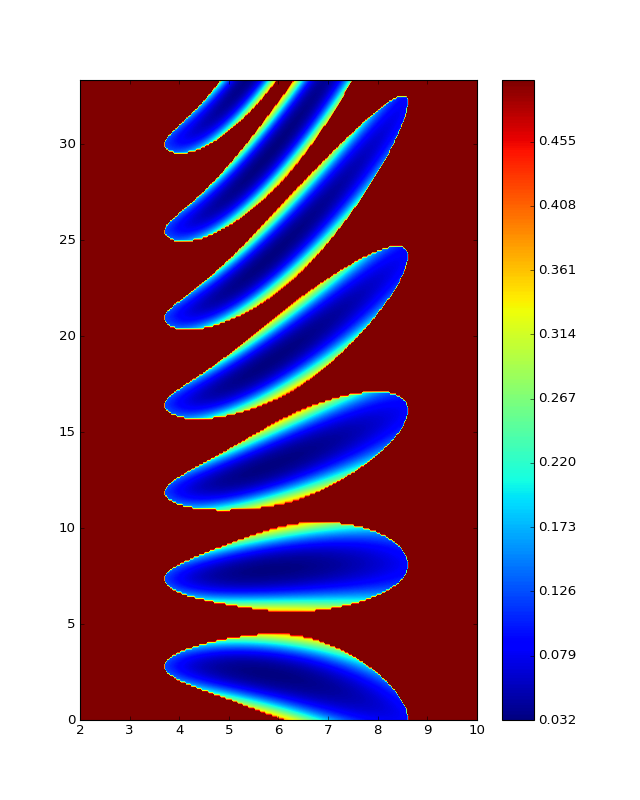

In [16]:
fig = plt.figure(8, figsize=(8,10))
D,T = meshgrid(distance_2, start_position_2)
P = ber_awgn_greed_2
plt.contourf(D, T, P, 500)                             
plt.colorbar()

In [45]:
distance_3 = np.linspace(3, 9., 1000)
time_3     = np.linspace(0, 10000, 1000)

# pathloss_greed_3 = prs.lin2db(make_space_time_greed_(distance, time, two_ray_, speed=tag_speed, polarization=1))
# rx_tag_greed_3       = make_space_time_greedle_(distance, time, rx_power_tag_complete_, speed=tag_speed)
# rx_reader_greed_3    = make_space_time_greed_(distance, time, rx_power_reader_complete_, speed=tag_speed)
ber_awgn_greed_3     = make_space_time_greed_(distance_3, time_3, ber_over_awgn_, speed=-1*tag_speed)
# ber_rayleigh_greed_3 = make_space_time_greed_(distance, time, ber_over_rayleigh_, speed=tag_speed)

<IPython.core.display.Javascript object>


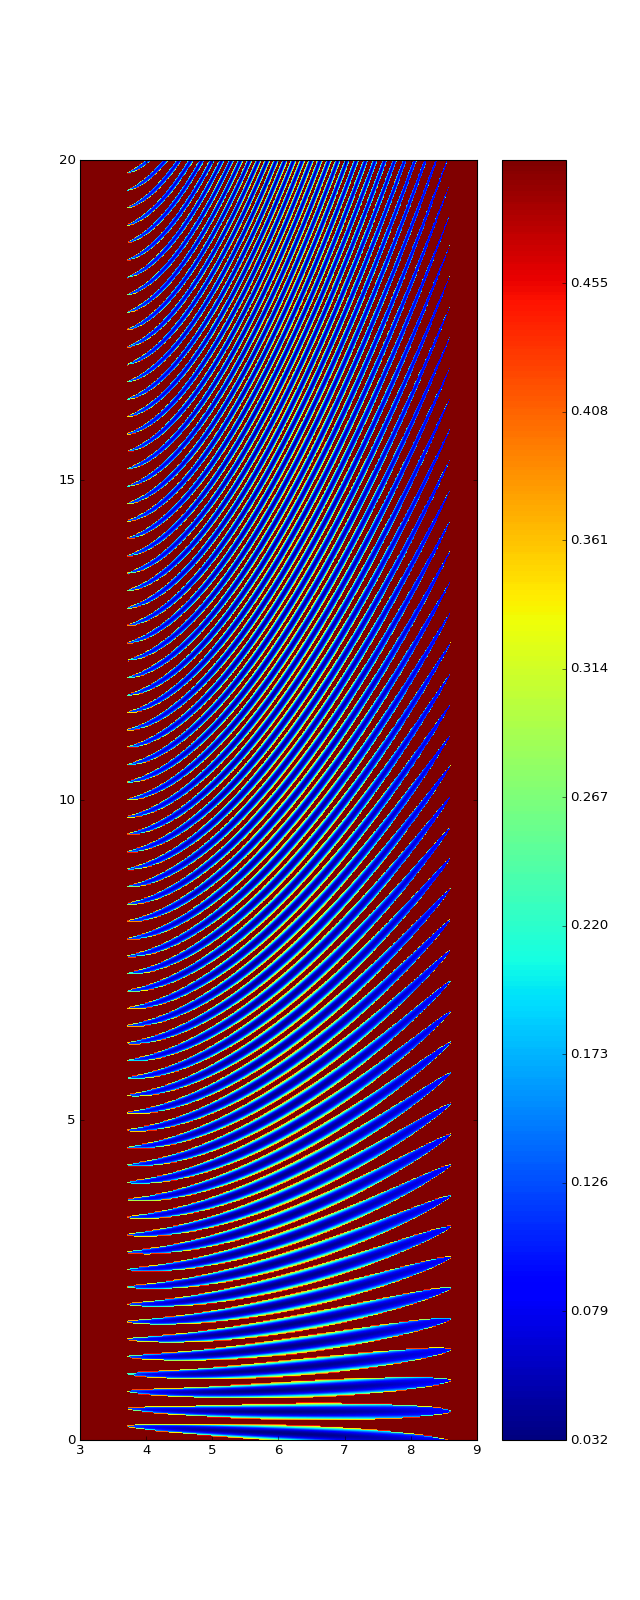

In [15]:
fig = plt.figure(8, figsize=(8,20))
D,T = meshgrid(distance_3, time_3)
P = ber_awgn_greed_3
plt.contourf(D, T, P, 500)                      
plt.colorbar()

In [43]:
ref_min = 0.1
ref_max = 0.4
ref = ref_min
counts = np.zeros(2000)

for t in range(2000):
    for d in range(2000):
        ber__ = ber_awgn_greed_3[t][d]
        if ref == ref_min and ber__ < ref:
            ref = ref_max
            counts[t] = counts[t] + 1
        elif ref == ref_max and ber__ > ref:
            ref = ref_min


<IPython.core.display.Javascript object>


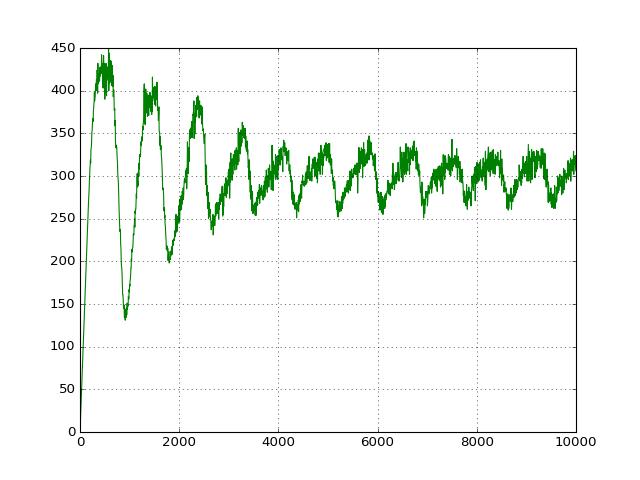

In [44]:
fig = figure(9)
ax = subplot(111)
plot(time_3, counts,'g', label='Free-space path loss')
grid(True)

In [7]:
tx_position_3d        = np.array([0,0,reader_height])
tx_direction_theta_3d = np.array([np.sin(np.pi/3), 0, -np.cos(np.pi/3)])
tx_direction_phi_3d   = np.array([0,1,0])
tx_velocity_3d        = np.array([0,0,0])

rx_direction_theta_3d = np.array([-1,0,0])
rx_direction_phi_3d   = np.array([0,-1,0])

def two_ray_3d_(distance, time, speed, polarization):
    return prs.two_ray_path_loss_3d(time=time, ground_reflection=prs.reflection, 
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_pos=tx_position_3d, tx_dir_theta=tx_direction_theta_3d, tx_dir_phi=tx_direction_phi_3d, 
            tx_velocity=tx_velocity_3d, tx_rp=prs.patch_rp,
            rx_pos=np.array([distance,0,tag_height]), rx_dir_theta=rx_direction_theta_3d, rx_dir_phi=rx_direction_phi_3d, 
            rx_velocity=np.array([-speed,0,0]), rx_rp=prs.dipole_rp, 
            wavelen=wave_length, width=wave_length/2, length=wave_length/2)

In [8]:
distance = np.linspace(2, 10., 300)
time     = np.linspace(0, 2, 300)

pathloss_greed = prs.lin2db(make_space_time_greed_(distance, time, two_ray_3d_, speed=tag_speed, polarization=1))
# rx_tag_greed       = make_space_time_greed_(distance, time, rx_power_tag_complete_, speed=tag_speed)
# rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_, speed=tag_speed)
# ber_awgn_greed     = make_space_time_greed_(distance, time, ber_over_awgn_, speed=tag_speed)
# ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_, speed=tag_speed)

<IPython.core.display.Javascript object>


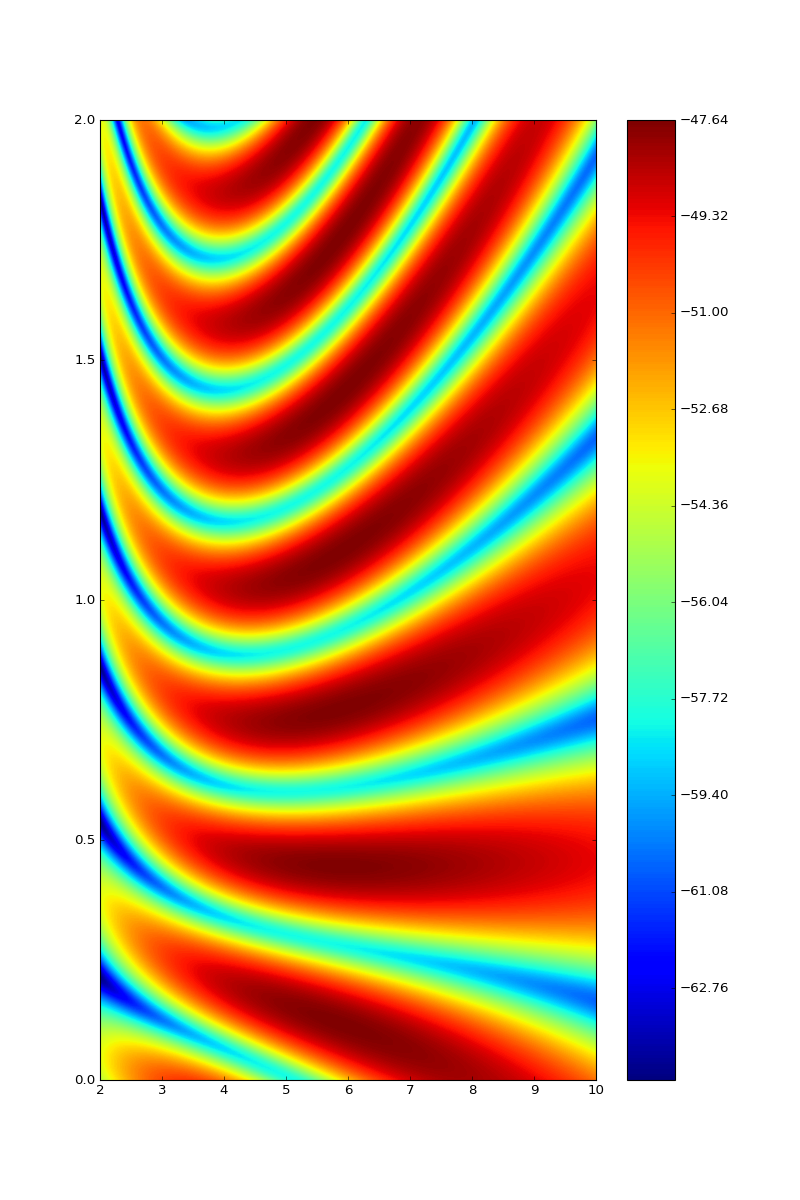

In [9]:
fig = plt.figure(5, figsize=(10,15))

D,T = meshgrid(distance, time)
P = pathloss_greed
plt.contourf(D, T, P, 500)            
plt.colorbar()
# savefig('100kmps_4sec.png')